In [45]:
%reload_ext autoreload
%autoreload 2

import hashlib
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import yaml

from firebase_admin import db
from library.config import get_config_declaration, get_config_options
from library.firebase import initialize_app, get_dataset_ref
from matplotlib.axes import Axes
from os import makedirs
from os.path import exists
from typing import Dict, Tuple

from library.design_space import get_design_space as get_design_space2, get_pareto_front

In [46]:
# MODE = "Detection"
MODE = "Tracking"

ENABLE_TRACKING = MODE == "Tracking"
ENABLE_PERSIST = MODE == "Detection"

VIDEO_FILES = [
    "VISO/car/003",
    "VISO/car/004",
    "VISO/car/005",
    "VISO/car/006",
    "VISO/car/007",
    "VISO/car/008",
    "VISO/car/009",
]

VIDEO_SCORES = {
    "VISO/car/003": (0.92, 0.92, 0.84),
    "VISO/car/004": (0.83, 0.89, 0.85),
    "VISO/car/005": (0.94, 0.88, 0.91),
    "VISO/car/006": (0.88, 0.93, 0.86),
    "VISO/car/007": (0.80, 0.84, 0.80),
    "VISO/car/008": (0.83, 0.85, 0.81),
    "VISO/car/009": (0.93, 0.73, 0.78)
}

RUNTIME_CONFIG = {
    "display": False,
    "save": True,
    "timings": False,
    "progress": True,
    "enable_tracking": ENABLE_TRACKING,
    "enable_persist": ENABLE_PERSIST
}

initialize_app()

In [47]:
def get_design_space(
    video_file: str, enable_tracking: bool, enable_persist: bool
):
    X, y, current_idx, known_idx = get_design_space2(video_file, enable_tracking, enable_persist)

    with open("./config_declaration.yml", "rb") as f:
        config_hash = hashlib.md5(f.read()).hexdigest()

    sherlock_ref = db.reference("sherlock")

    video_file_ref = get_dataset_ref(video_file, sherlock_ref)
    config_declaration_ref = video_file_ref.child(config_hash)

    if enable_tracking:
        tracking_ref = config_declaration_ref.child("tracking_enabled")
    else:
        tracking_ref = config_declaration_ref.child("tracking_disabled")

    if enable_persist:
        persist_ref = tracking_ref.child("persist_enabled")
    else:
        persist_ref = tracking_ref.child("persist_disabled")

    current_idx = np.array(current_idx)
    current_outputs = np.array(y[current_idx, :])

    known_idx = np.array(known_idx)
    known_outputs = np.array(y[known_idx, :])
        
    ypredict, ypredict_idx, = get_pareto_front(video_file, enable_tracking, enable_persist)

    return y, current_idx, current_outputs, known_outputs, known_idx, ypredict, ypredict_idx, persist_ref

def get_results(
    video_file: str,
    enable_tracking: bool,
    enable_persist: bool,
    reference_video_file: str,
    ax: Axes,
):
    if reference_video_file:
        reference_video_idx = VIDEO_FILES.index(reference_video_file)

    video_idx = VIDEO_FILES.index(video_file)

    (
        y,
        current_idx,
        current_outputs,
        known_outputs,
        known_idx,
        ypredict,
        ypredict_idx,
        storage_ref,
    ) = get_design_space(video_file, enable_tracking, enable_persist)

    ax.scatter(
        current_outputs[:, 0],
        current_outputs[:, 1],
        c="blue",
        marker="^",
        label="Sampled designs",
    )
    ax.scatter(
        ypredict[:, 0],
        ypredict[:, 1],
        c="red",
        label="Predicted Pareto designs",
    )

    if reference_video_file and video_idx != reference_video_idx:
        _, _, _, _, _, _, ref_ypredict_idx, _ = get_design_space(
            reference_video_file, enable_tracking, enable_persist
        )

        known_idx_set = {idx for idx in known_idx}
        filtered_idx = [idx for idx in ref_ypredict_idx if idx in known_idx_set]
        requested_idx = [
            int(idx) for idx in ref_ypredict_idx if idx not in known_idx_set
        ]

        requested_idx_ref = storage_ref.child("requested_idx")
        requested_idx_ref.set(requested_idx)

        ax.scatter(
            y[filtered_idx, 0],
            y[filtered_idx, 1],
            c="orange",
            marker="+",
            label=f"Predicted Pareto designs for Video {reference_video_idx + 1}",
        )

    ax.set_title(
        f"Video {video_idx + 1}"
        # + f" with Tracking {'Enabled' if enable_tracking else 'Disabled'}"
        # + f" and Persistence {'Enabled' if enable_persist else 'Disabled'}"
        # + " Design Space"
    )
    ax.set(xlabel="Recall", ylabel="Precision")
    # ax.label_outer()
    # ax.legend()
    # plt.legend(bbox_to_anchor=(1.05, 1.05))
    # plt.xlabel("Recall")
    # plt.ylabel("Precision")
    ax.set_xlim(known_outputs[:, 0].min(), known_outputs[:, 0].max())
    ax.set_ylim(known_outputs[:, 1].min(), known_outputs[:, 1].max())

    # plt.show()

In [48]:
def get_row_col(i: int):
    col = i % 3
    row = math.floor(i / 3)

    return (row, col)

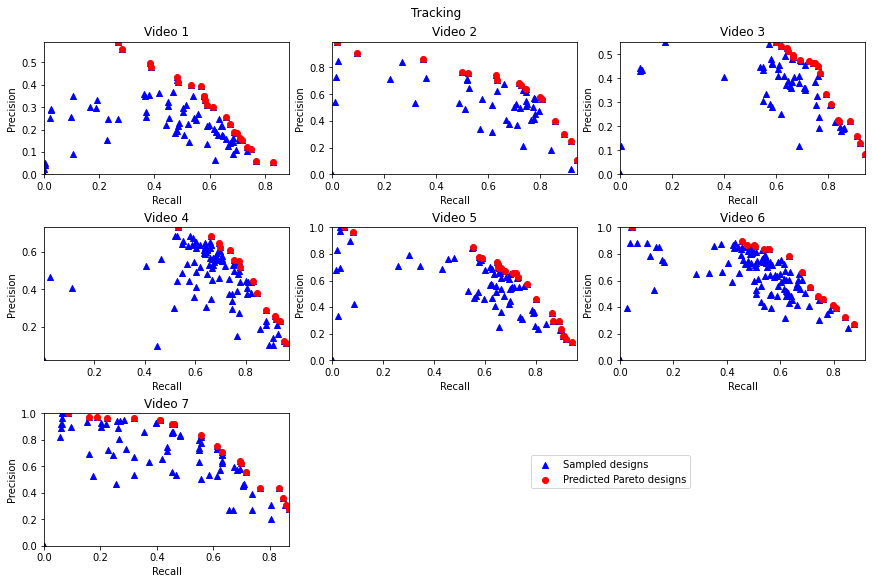

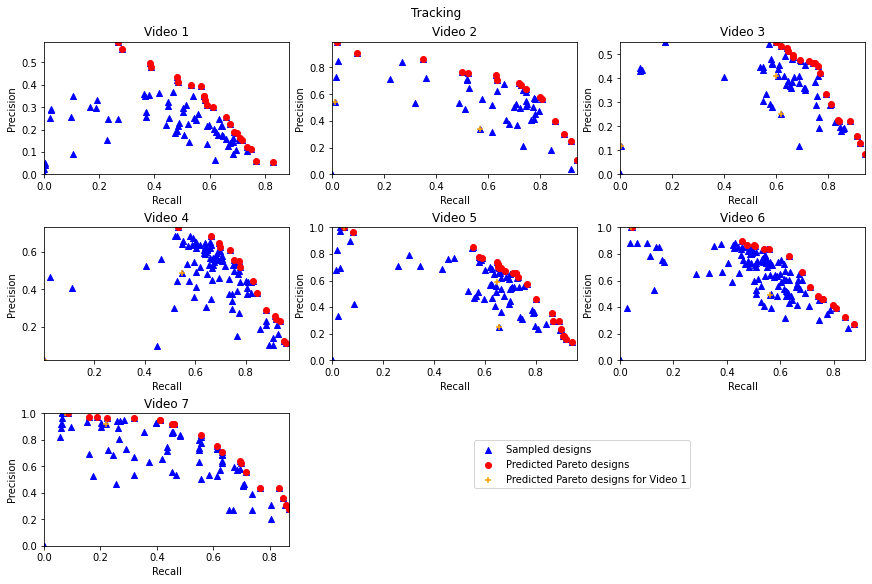

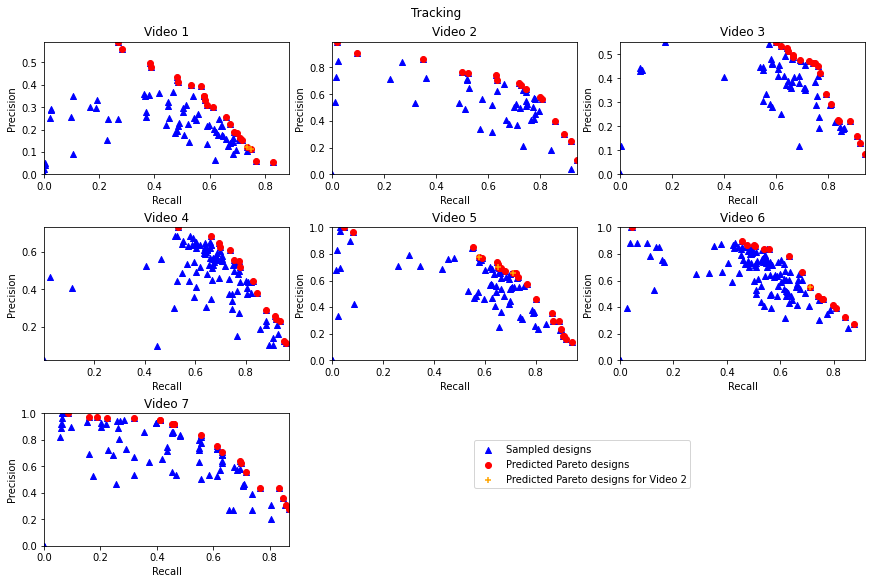

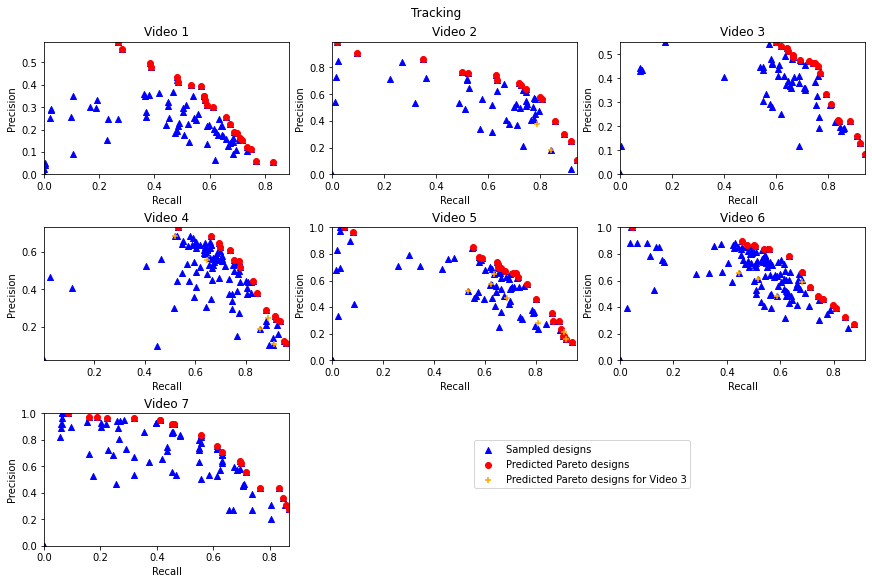

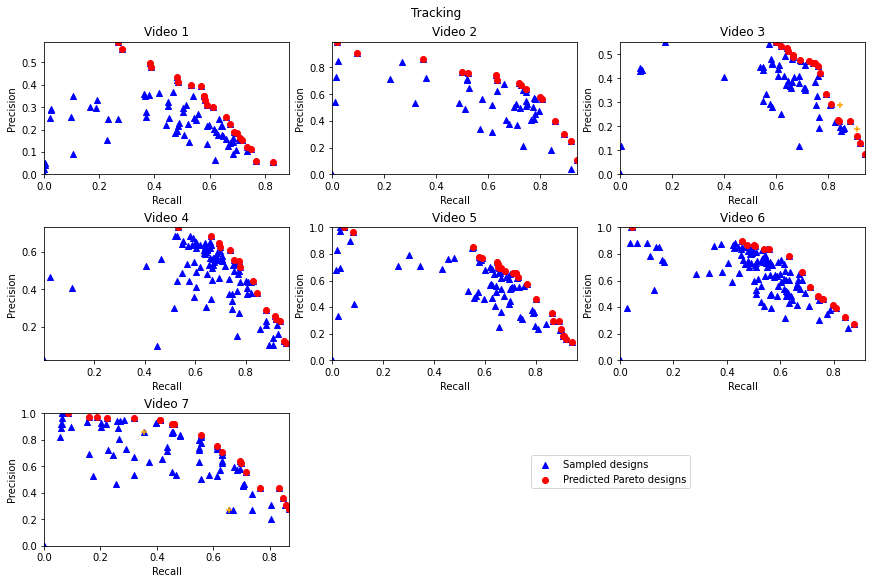

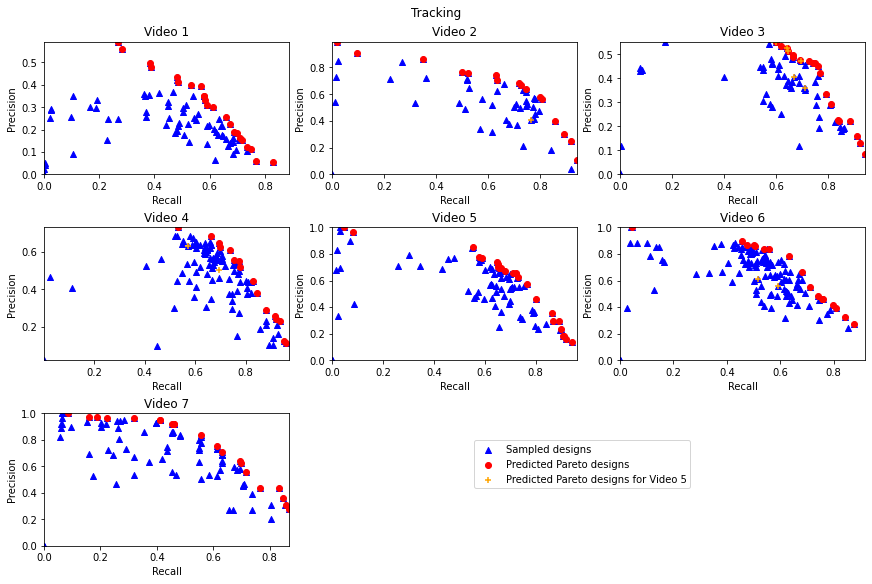

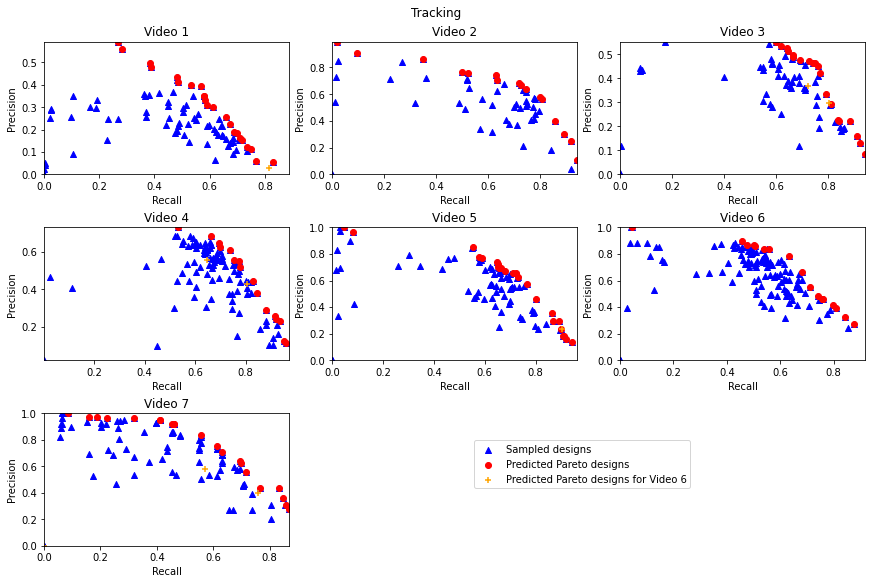

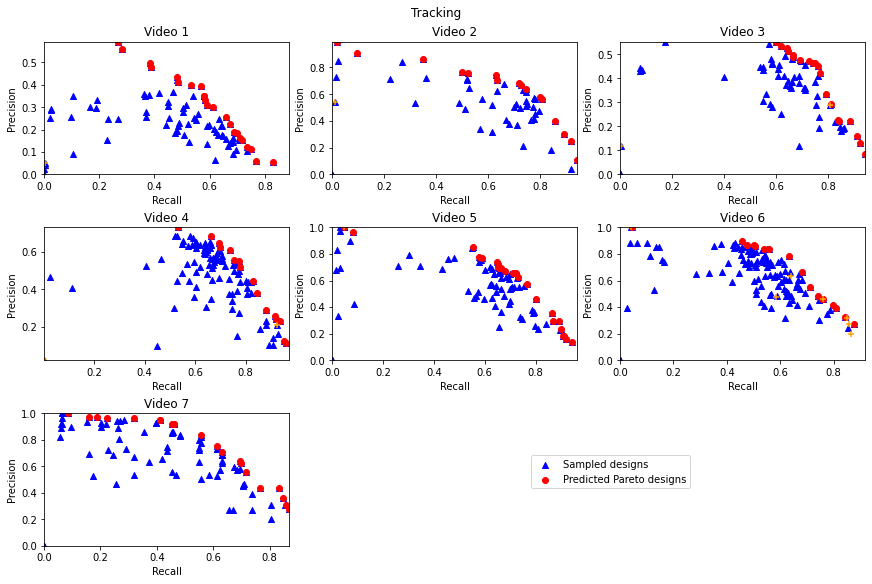

In [49]:
video_files = [None]
video_files.extend(VIDEO_FILES)

for ref_idx, ref_video_file in enumerate(video_files):
    ref_idx -= 1
    if ref_idx != -1:
        ref_r, ref_c = get_row_col(ref_idx)

        if ref_r == 0 and ref_c == 0:
            ref_r = 1

    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 8), constrained_layout=True)
    fig.delaxes(axs[2][1])
    fig.delaxes(axs[2][2])
    for i, video_file in enumerate(VIDEO_FILES):
        r, c = get_row_col(i)

        get_results(
            video_file, ENABLE_TRACKING, ENABLE_PERSIST, ref_video_file, axs[r, c]
        )

    if ref_idx == -1:
        ref_r = 0

    handles, labels = axs[ref_r, 0].get_legend_handles_labels()
    fig.legend(
        handles, labels, loc="lower right", bbox_to_anchor=(0.8, 0.15)
    )

    makedirs("./output/figures", exist_ok=True)

    if ref_idx == -1:
        path = f"./output/figures/fig_{'tracking' if ENABLE_TRACKING else 'detection'}_pareto.pdf"
    else:
        path = f"./output/figures/fig_{'tracking' if ENABLE_TRACKING else 'detection'}_pareto_ref{ref_idx + 1}.pdf"

    fig.suptitle(f"{'Tracking' if ENABLE_TRACKING else 'Detection'}")
    plt.savefig(path, format="pdf")



In [50]:
names = []
idxes = []
recalls = []
precisions = []
f1s = []

for i, video_file in enumerate(VIDEO_FILES):
    (
        y,
        current_idx,
        current_outputs,
        _,
        _,
        ypredict,
        ypredict_idx,
        storage_ref,
    ) = get_design_space(video_file, ENABLE_TRACKING, ENABLE_PERSIST)

    for idx, (output) in zip(current_idx, current_outputs):
        idx = idx
        recall = output[0]
        precision = output[1]
        f1 = output[2]

        names.append(f"Video {i + 1}")
        idxes.append(idx)
        recalls.append(recall)
        precisions.append(precision)
        f1s.append(f1)

df = pd.DataFrame()
df["Video Name"] = names
df["idx"] = idxes
df["Recall"] = recalls
df["Precision"] = precisions
df["F1"] = f1s

df.to_csv("./output/pareto_front.csv")

In [51]:
avg_recall = np.zeros(3)
avg_precision = np.zeros(3)
avg_f1 = np.zeros(3)

required_avg_recall = 0.84
required_avg_precision = 0.85
required_avg_f1 = 0.84

for video_file in VIDEO_FILES:
    (
        _,
        _,
        _,
        _,
        _,
        ypredict,
        ypredict_idx,
        storage_ref,
    ) = get_design_space(video_file, ENABLE_TRACKING, ENABLE_PERSIST)

    max_recall_idx = np.argmax(ypredict[:, 0])
    max_precision_idx = np.argmax(ypredict[:, 1])
    max_f1_idx = np.argmax(ypredict[:, 2])

    max_recall = ypredict[max_recall_idx, :]
    max_precision = ypredict[max_precision_idx, :]
    max_f1 = ypredict[max_f1_idx, :]

    avg_recall += max_recall
    avg_precision += max_precision
    avg_f1 += max_f1

    recall_color = "\033[0m"
    precision_color = "\033[0m"
    f1_color = "\033[0m"

    recall, precision, f1 = VIDEO_SCORES[video_file]

    if max_recall[0] >= recall:
        recall_color = "\033[94m"

    if max_precision[1] >= precision:
        precision_color = "\033[94m"

    if max_f1[2] >= f1:
        f1_color = "\033[94m"

    print(video_file)
    print(f"{recall_color}Max Recall: {max_recall}\033[0m => {recall}")
    print(f"{precision_color}Max Precision: {max_precision}\033[0m => {precision}")
    print(f"{f1_color}Max F1: {max_f1}\033[0m => {f1}")
    print("=" * 10)

avg_recall /= 7.0
avg_precision /= 7.0
avg_f1 /= 7.0

recall_color = "\033[0m"
precision_color = "\033[0m"
f1_color = "\033[0m"

recall, precision, f1 = VIDEO_SCORES[video_file]

if avg_recall[0] >= required_avg_recall:
    recall_color = "\033[94m"

if avg_precision[1] >= required_avg_precision:
    precision_color = "\033[94m"

if avg_f1[2] >= required_avg_f1:
    f1_color = "\033[94m"

print("Average")
print(f"{recall_color}Max Recall: {avg_recall}\033[0m => {required_avg_recall}")
print(f"{precision_color}Max Precision: {avg_precision}\033[0m => {required_avg_precision}")
print(f"{f1_color}Max F1: {avg_f1}\033[0m => {required_avg_f1}")
print("=" * 10)

VISO/car/003
Max Recall: [0.83149587 0.05532147 0.10374081] => 0.92
Max Precision: [0.26949556 0.59189003 0.37036081] => 0.92
Max F1: [0.56857964 0.39411535 0.46553886] => 0.84
VISO/car/004
Max Recall: [0.94328815 0.11109107 0.19877268] => 0.83
Max Precision: [0.02033471 0.99122807 0.03985188] => 0.89
Max F1: [0.72083783 0.68362403 0.70173791] => 0.85
VISO/car/005
Max Recall: [0.94170231 0.08533823 0.15649472] => 0.94
Max Precision: [0.59809779 0.55132611 0.57376034] => 0.88
Max F1: [0.63958323 0.52556751 0.57699687] => 0.91
VISO/car/006
Max Recall: [0.95856384 0.11425579 0.20417499] => 0.88
Max Precision: [0.53385445 0.7297216  0.61660732] => 0.93
Max F1: [0.66362135 0.68620533 0.67472441] => 0.86
VISO/car/007
Max Recall: [0.94111994 0.13789899 0.2405509 ] => 0.8
Max Precision: [0.04878049 1.         0.09302326] => 0.84
Max F1: [0.64632437 0.74226352 0.69097967] => 0.8
VISO/car/008
Max Recall: [0.8770793  0.2752018  0.41894951] => 0.83
Max Precision: [0.04494382 1.         0.08602151]